# UJIIndoorLoc WLAN Fingerprint dataset EDA

In this notebook, I begin from the raw UJIIndoorLoc dataset and perform an initial exploratory data analysis on the distributions of the predictors and response variables. This is followed by dimensionality reduction analysis. Once the data is prepared, I focus on the model selection and finally ensemble learning.

## Table of Contents

* [Dataset Description](#dataset-description)

* [Data Pre-Processing](#preprocess)

* [Exploratory Data Analysis](#eda)

* [Skewness and Kurtosis](#skew-kurtosis)

* [Box-Cox Transformation](#box-cox)

* [Dimensionality Reduction](#dimension-reduction)

* [Predictor Correlations](#predictor-correlations)

* [Principal Component Analysis (PCA)](#pca)

In [51]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [52]:
train_data = pd.read_csv("data/trainingData.csv")
test_data = pd.read_csv("data/validationData.csv")

# Dataset Description <a id='dataset-description'></a>

Source: https://www.kaggle.com/giantuji/UjiIndoorLoc

- **WAP001-WAP520**: Intensity value for **Wireless Access Point** (WAP). WAP will be the acronym used for rest of this notebook. Negative integer values from -104 to 0 and +100. **Censored data:** Positive value 100 used if WAP was not detected.

- **Longitude**: Longitude. Negative real values from -7695.9387549299299000 to -7299.786516730871000

- **Latitude**: Latitude. Positive real values from 4864745.7450159714 to 4865017.3646842018.

- **Floor**: Altitude in floors inside the building. Integer values from 0 to 4.

- **BuildingID**: ID to identify the building. Measures were taken in three different buildings. Categorical integer values from 0 to 2.

- **SpaceID**: Internal ID number to identify the Space (office, corridor, classroom) where the capture was taken. Categorical integer values.

- **RelativePosition**: Relative position with respect to the Space (1 - Inside, 2 - Outside in Front of the door). Categorical integer values.

- **UserID**: User identifier (see below). Categorical integer values.

- **PhoneID**: Android device identifier (see below). Categorical integer values.

- **Timestamp**: UNIX Time when the capture was taken. Integer value.

In [53]:
train_data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [54]:
train_data.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,...,100.0,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,...,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,...,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7594.737000,4.864821e+06,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7423.060900,4.864852e+06,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7359.193000,4.864930e+06,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7300.818990,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


In [55]:
# Response variables in our problem are Building, Floor, Latitude, Longitude and Relative Position
(train_data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']]
.astype(str)
.describe(include=['object']))

,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID
count,19937,19937,19937,19937,19937,19937
unique,5,3,123,2,18,16
top,3,2,202,2,11,14
freq,5048,9492,484,16608,4516,4835


From the [paper](http://ieeexplore.ieee.org/document/7275492/) on this dataset:
"Although both the training subset and the validation subset contain the same information, the latter includes the value 0 in some fields. These fields are: SpaceID, Relative Position with respect to SpaceID and UserID. As it has been commented before, this information was not recorded because the validation captures were taken at arbitrary points and the users were not tracked in this phase. **This fact tries to simulate a real localization system.**"

Hence, Space ID, Relative Position, User ID won't be used to model the Localization algorithm. Also, Phone iD won't be used as in a real system, new phones should be localized without being used in the training.

Next, I focus on the pre-processing of the WAP RSSI columns.

#  Data Pre-Processing <a id='preprocess'></a>

## Exploratory Data Analysis <a id='eda'></a>

In [56]:
wap_train = train_data.iloc[:,:520]
wap_test = test_data.iloc[:,:520]
wap_train.shape

(19937, 520)

In [57]:
wap_train = (wap_train
             .replace(to_replace=100,value=np.nan))

# Perform the same transform on Test data
wap_test = (wap_test
             .replace(to_replace=100,value=np.nan))

We are replacing the out-of-range values with NaN to avoid disturbance to our analysis on in-range RSSI distribution.

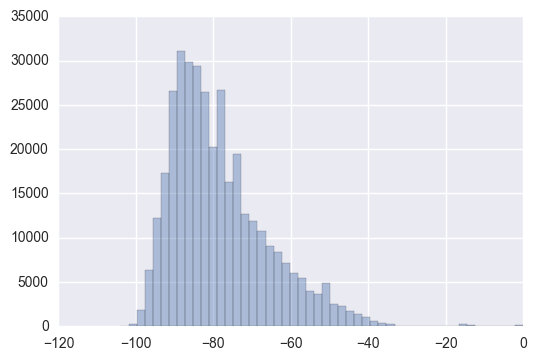

In [58]:
wap_stack = wap_train.stack(dropna=False)
sns.distplot(wap_stack.dropna(),kde = False)

Skewness is a measure of asymmetry of distribution. Clearly, the distribution above appears right-skewed with majority of the values being on the left side of the distribution. Let's look at the skewness value for inidividual WAP RSSI distributions! We might have to perform a log/ Box-Cox transformation to overcome the skewness. 

Let's look at percentage of out-of-range overall and column wise.

In [59]:
# Proportion of out of range values
sum(wap_stack.isnull() == 0)/len(wap_stack)

0.034605449473533938

**96.1% of the values in the matrix represent Out-of-Range.** This is expected as for any given measurement, only a subset of the APs might be in reach of the mobile device.

For this purpose, let's analyze the ditribution of number of APs in range for the training data samples.

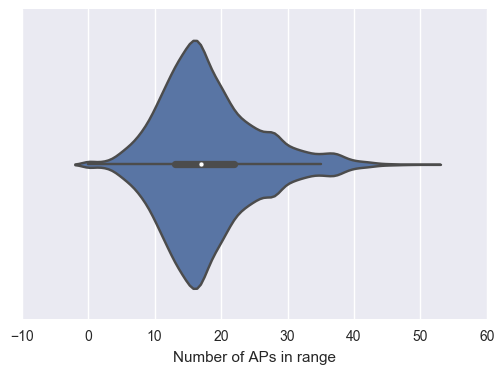

In [60]:
waps_in_range = (wap_train
                 .notnull()
                 .sum(axis = 1))

fig, ax = plt.subplots(1,1)

sns.violinplot(waps_in_range, ax = ax)
ax.set_xlabel("Number of APs in range")

In [61]:
waps_in_range.describe()

count    19937.000000
mean        17.994834
std          7.333575
min          0.000000
25%         13.000000
50%         17.000000
75%         22.000000
max         51.000000
dtype: float64

Interestingly, majority of the samples have over 13 APs in range with the maximum of 51 APs. We do observe some of the training samples with 0 APs in range. Let's remove these samples from the training data.

In [62]:
print("Before sample removal:", len(wap_train))

wap_train = (wap_train
             .loc[wap_train
                  .notnull()
                  .any(axis=1),:])

print("After sample removal:", len(wap_train))

Before sample removal: 19937
After sample removal: 19861


We cannot delete training samples with just a single AP or few APs in range as that is the best information we have to localize. 

We can remove the RSSI columns related to APs which are not in range in any of our training samples.

In [63]:
# Removing columns with all NaN values
all_nan = (wap_train
           .isnull()
           .all(axis=0) == False)
filtered_cols = (all_nan[all_nan]
                 .index
                 .values)

print("Before removing predictors with no in-range values", wap_train.shape)

wap_train = wap_train.loc[:,filtered_cols]
wap_test = wap_test.loc[:,filtered_cols]

print("After removing predictors with no in-range values", wap_train.shape)

Before removing predictors with no in-range values (19861, 520)
After removing predictors with no in-range values (19861, 465)


## Skewness and Kurtosis <a id="skew-kurtosis"></a>

Skewness and kurtosis metrics are common measures to find out how close a distribution is to the normal distribution. When the data is far away from normality statistic significantly, Box-Cox transformation is one way to satisfy the normality. This is necessary for standard statistical tests, and also sometimes to satisfy the linear and/or the equal variance assumptions for a standard linear regression model

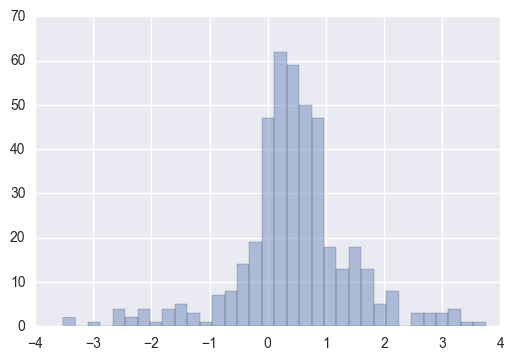

In [64]:
# Finding skewness ignoring NaN values
wap_skew = wap_train.skew()

sns.distplot(wap_skew.dropna(),kde=False)

We can observe majority of the WAP columns have a low to medium positive skewness in the region (0,1). There are still a few columns outside the (1,-1) range typically considered an acceptable range of skewness.

Next, before we apply the Normality tests, we need to fill in the out-of-range values which are currently NaN. Box-Cox transformation requires all values to be positive. For this purpose, let's transform our predictors to normal scale from the dBm scale.

Also, the out-of-range values are transformed to 1/hundreth of the absolute minimum among all in-range values. Therefore, the transformed out-of-range value represents the minimum RSSI value in the dataset.

In [65]:
wap_exp_train = np.power(10,wap_train/10,)
wap_exp_test = np.power(10,wap_test/10)

abs_min = (wap_exp_train.apply(min).min())/100

wap_exp_train.fillna(abs_min,inplace=True)
wap_exp_test.fillna(abs_min,inplace=True)

In [66]:
a = pd.DataFrame({
        'a': [-2, -3, 4],
        'b': [-6,-7,-8]
    })

print(a)

a += 4

print(a)

   a  b
0 -2 -6
1 -3 -7
2  4 -8
   a  b
0  2 -2
1  1 -3
2  8 -4


### Normality test 

In this sub-section, I will explore various normality tests and explore the distributions of  RSSI predictors.

1. **Skew test**: Z-score of the test in which the null hypothesis states that that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution.

2. **Kurtosis test**: Z-score of the test in which the null hypothesis states that the kurtosis of the population from which the sample was drawn is that of the normal distribution: kurtosis = 3(n-1)/(n+1).

3. **k2**: $s^2 + k^2$, where $s$ is the z-score returned by skew test and $k$ is the z-score returned by kurtosistest.

4. **p_value**: A 2-sided chi squared probability for the hypothesis test that the sample comes from a normal distribution. Same test as k2. 

In [67]:
from scipy.stats.mstats import normaltest, skewtest, kurtosistest, skew, kurtosis

def normal_test(s):
    s = s.dropna()
    
    # Minimum samples required for Kurtosis = 21
    # Minimum samples required for Skewness = 8
    if len(s) <=20:
        return [np.nan, np.nan]
    k2, pvalue = normaltest(s)
    return list(normaltest(s))

def skew_test(s):
    s = s.dropna()
    
    # Minimum samples required for Skewness = 8
    if len(s) <=8:
        return np.nan
    z_score,pval = skewtest(s)
    return z_score

def kurtosis_test(s):
    s = s.dropna()
    
    # Minimum samples required for Kurtosis = 21
    if len(s) <=20:
        return np.nan
    z_score,pval = kurtosistest(s)
    return z_score

def skew_score(s):
    s = s.dropna()
    return float(skew(s).data)

def kurtosis_score(s):
    s = s.dropna()
    return kurtosis(s)

def in_range(s):
    return (s > abs_min).sum()

In [68]:
wap_norm = pd.DataFrame({'Sample_Size': wap_exp_train.apply(in_range),
                         #'Normality': wap_train.apply(normal_test),
                         'Skewness': wap_exp_train.apply(skew_score),
                         'Kurtosis': wap_exp_train.apply(kurtosis_score),
                         #'Skew_Test': wap_exp_train.apply(skew_test),
                         #'Kurtosis_Test': wap_exp_train.apply(kurtosis_test)
                        })

'''
wap_norm['k2'] = (wap_norm['Normality']
                 .apply(lambda x: x[0]))

wap_norm['p_value'] = (wap_norm['Normality']
                 .apply(lambda x: x[1]))

wap_norm.drop('Normality', axis = 1,inplace = True)
'''

wap_norm.head(15)

,Kurtosis,Sample_Size,Skewness
WAP001,1446.197287,18,36.840553
WAP002,1550.899470,19,38.522740
WAP005,926.327038,40,28.811192
WAP006,2649.453377,308,49.201573
WAP007,2544.326536,578,48.199114
WAP008,271.541545,677,15.904351
WAP009,1607.522615,595,36.942928
WAP010,1260.656809,87,32.866402
WAP011,8749.417192,2956,91.377383
WAP012,2186.418420,2983,46.709112


Let's explore the relationship between Kurtosis scores and Skew scores.

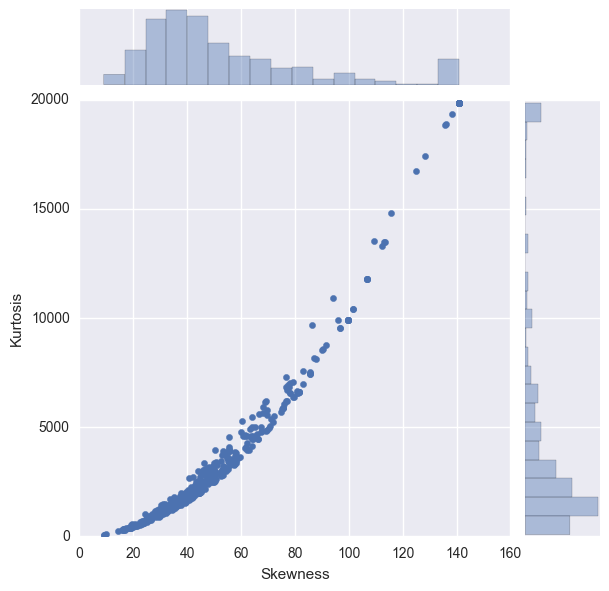

In [69]:
sns.jointplot(y="Kurtosis", x="Skewness", stat_func= None, data=wap_norm)

**Skewness:** For normally distributed data, the skewness should be about 0. A skewness value > 0 means that there is more weight in the left tail of the distribution. Similarly, a negative value indicates a left-skewed distribution with more weight on the right tail.

Clearly, many of the predictors have a skewness outside the expected range of 0,0

**Kurtosis:** Kurtosis is the fourth central moment divided by the square of the variance. If a distribution has  positive kurtosis, that means it has more in the tails than the normal distribution. Similarly, if a distribution has a negative kurtosis, it has less in the tails than the normal distribution. 

In the above figure, for the columns with a higher skewness score, the kurtosis is also more extreme.

The statistical significance of the Skewness and Kurtosis scores can be checked plotting the z-scores of the Skew test and Kurtosis tests.

In [70]:
#sns.jointplot(y="Kurtosis_Test", x="Skew_Test", data=wap_norm)

## Box-Cox Transformation <a id="box-cox"></a>

To apply the Box-Cox transform we have to first make all our data positive. As we performed the exponential transformation, our data is already positive.

For example, let's observe the how the Box-Cox transformation parameter $\lambda$ is fit for the first WAP RSSI predictor column in our current filtered training set. The figure below shows the Probability Plot Correlelation Coefficient, as obtained from probplot when fitting the Box-Cox transformed input predictor against a normal distribution.

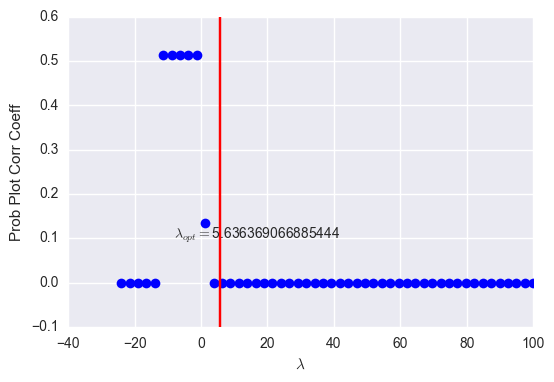

In [71]:
lmbdas, pppc = stats.boxcox_normplot(wap_exp_train.iloc[:,100], -100, 100)

fig,ax = plt.subplots(1,1)
ax.plot(lmbdas,pppc,'bo')

_, maxlog = stats.boxcox(wap_exp_train.iloc[:,0])
ax.axvline(maxlog, color='r')

ax.set_xlabel("$\lambda$")
ax.set_ylabel("Prob Plot Corr Coeff")
ax.text(x = -8, y = 0.1, s="$\lambda_{opt} = $" + str(maxlog))

The maximum log likelihood function peaks at $\lambda = 1.1437$. Next, let's find out the $\lambda$s for different columns in our dataset.

In [72]:
def box_cox_lambda(s):
    _, maxlog = stats.boxcox(s)
    return maxlog

In [73]:
lambda_bc = wap_exp_train.apply(box_cox_lambda)

wap_boxcox_train = wap_exp_train
wap_boxcox_test = wap_exp_test

for wap in wap_boxcox_train:
    # Training data transform
    wap_boxcox_train.loc[:,wap] = stats.boxcox(wap_exp_train.loc[:,wap],lmbda = lambda_bc.loc[wap])
    # Test data transform
    wap_boxcox_test.loc[:,wap] = stats.boxcox(wap_exp_test.loc[:,wap],lmbda = lambda_bc.loc[wap])

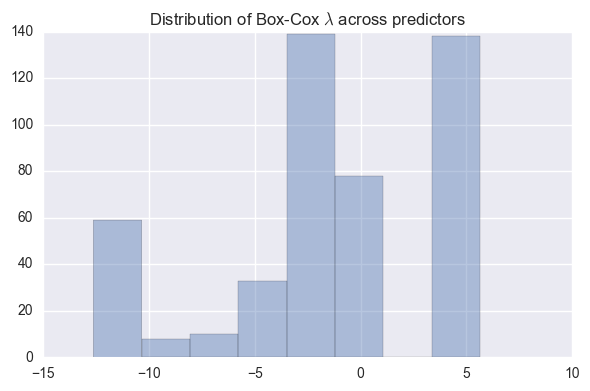

In [74]:
sns.distplot(lambda_bc, kde = False)
plt.title("Distribution of Box-Cox $\lambda$ across predictors")
plt.tight_layout()

The above figure shows the distribution of $\lambda$s that maximize log-likelihood function for each predictor. We can observe the two biggestbars are located at +5 and -2.5.

In [75]:
# After Box-Cox
wap_norm_post_boxcox = pd.DataFrame({'Skewness': wap_boxcox_train.apply(skew_score),
                         'Kurtosis': wap_boxcox_train.apply(kurtosis_score),
                         'BoxCox_Lambda': lambda_bc})

wap_norm_post_boxcox.head(10)

,BoxCox_Lambda,Kurtosis,Skewness
WAP001,5.636369,-3,0.000000
WAP002,5.636369,-3,0.000000
WAP005,5.636369,-3,0.000000
WAP006,-7.517451,--,7.842163
WAP007,-3.609156,29.3916,5.602818
WAP008,-3.106617,24.3721,5.135374
WAP009,-3.206752,28.4107,5.514591
WAP010,5.636369,-3,0.000000
WAP011,-0.588887,1.89461,1.973406
WAP012,-0.584129,1.83559,1.958402


The kurtosis and skewness seems to have greatly reduced compared to before the Box-Cox transformation. Let's compare!

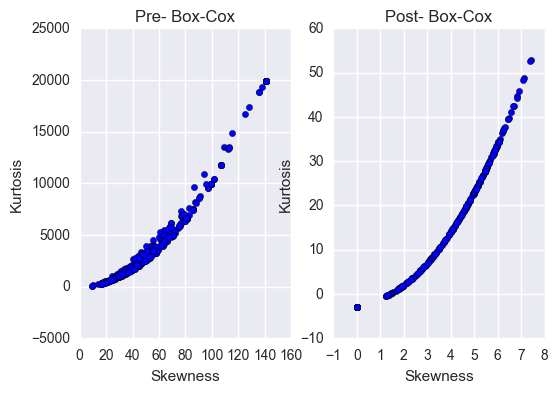

In [76]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.scatter(y="Kurtosis", x="Skewness", data=wap_norm)
ax1.set_xlabel("Skewness")
ax1.set_ylabel("Kurtosis")
ax1.set_title("Pre- Box-Cox")

ax2.scatter(y="Kurtosis", x="Skewness", data=wap_norm_post_boxcox)
ax2.set_xlabel("Skewness")
ax2.set_ylabel("Kurtosis")
ax2.set_title("Post- Box-Cox")

Note that the scales for the two figures above are two orders of magnitude lower for Kurtosis and one order of mangnitude lower for Skewness after the Box-Cox transformation.

I am interested in observing the univariate distribution of skewness and kurtosis to find out if majority of our predictors are now close to normal or not.

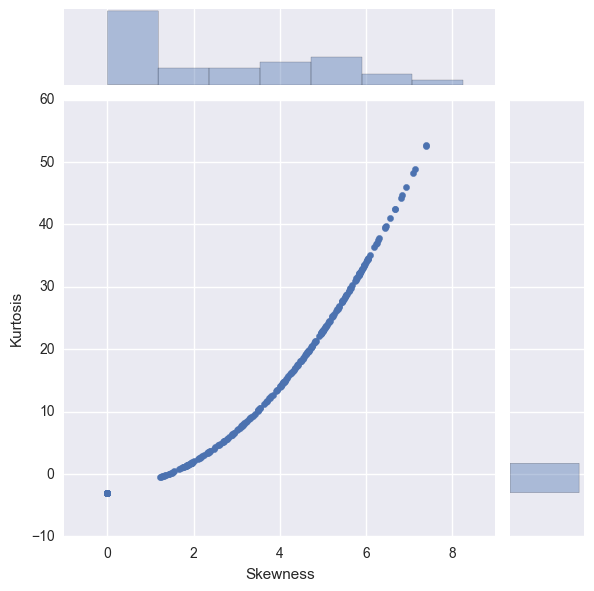

In [77]:
sns.jointplot(y="Kurtosis", x="Skewness", stat_func = None,data=wap_norm_post_boxcox)

We can observe the biggest bars are located in the region [0,1) for skewness and [0,-3) for kurtosis. 

At this point, we can remove the predictors that have high skewness (> 3) or high kurtosis (> 1). However, as predictor corresponds to RSSI distribution of a single WAP, there might be samples for which one or more of these WAPs might be the closest and correspondingly have the highest measure. For this purpose, I do not perform any predictor selection at this stage.

Instead, we can explore how much of the variance in the dataset is explained by the predictors using Principal Component Analysis (PCA).

# Dimensionality Reduction <a id = "dimension-reduction"></a>

Dimensionality reduction is one of the key techniques to reduce the complexity. 

PCA is a simple dimensionality reduction technique that applies linear transformations on the original space. Among all the orthogonal linear projections, PCA minimizes the **reconstruction error**, which is the distance between the instance and its reconstruction from the lower-dimensional space. That is sum of the distances between points in original space and the corresponding points in lower-dimensional space.

Before we can perform the PCA analysis, we need to bring the predictors to the same scale. Then, we analyze the correlations between the predictors and remove highly correlated predictors. This is because adjoining nearly correlated variables increases the contribution of their common underlying factor to the PCA. We can remove highly correlated predictors algorithmically or removing the correlations by whitening the data (conversion to Identity Covariance Matrix).

## Feature Scaling

Most models require the predictors to be on the same scale for better performancee. The main exceptions are decision-tree based models which are not dependent on scaling as the splits are univariate.

In [78]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(wap_boxcox_train)
X_test_std = sc.transform(wap_boxcox_test)

In [79]:
X_train_std.shape, X_test_std.shape

((19861, 465), (1111, 465))

## Predictor Correlations <a id="predictor-correlations"></a>

[Read this explanation](http://stats.stackexchange.com/questions/50537/should-one-remove-highly-correlated-variables-before-doing-pca) about how PCA tends to over-emphasize the contributions of correlated predictors.

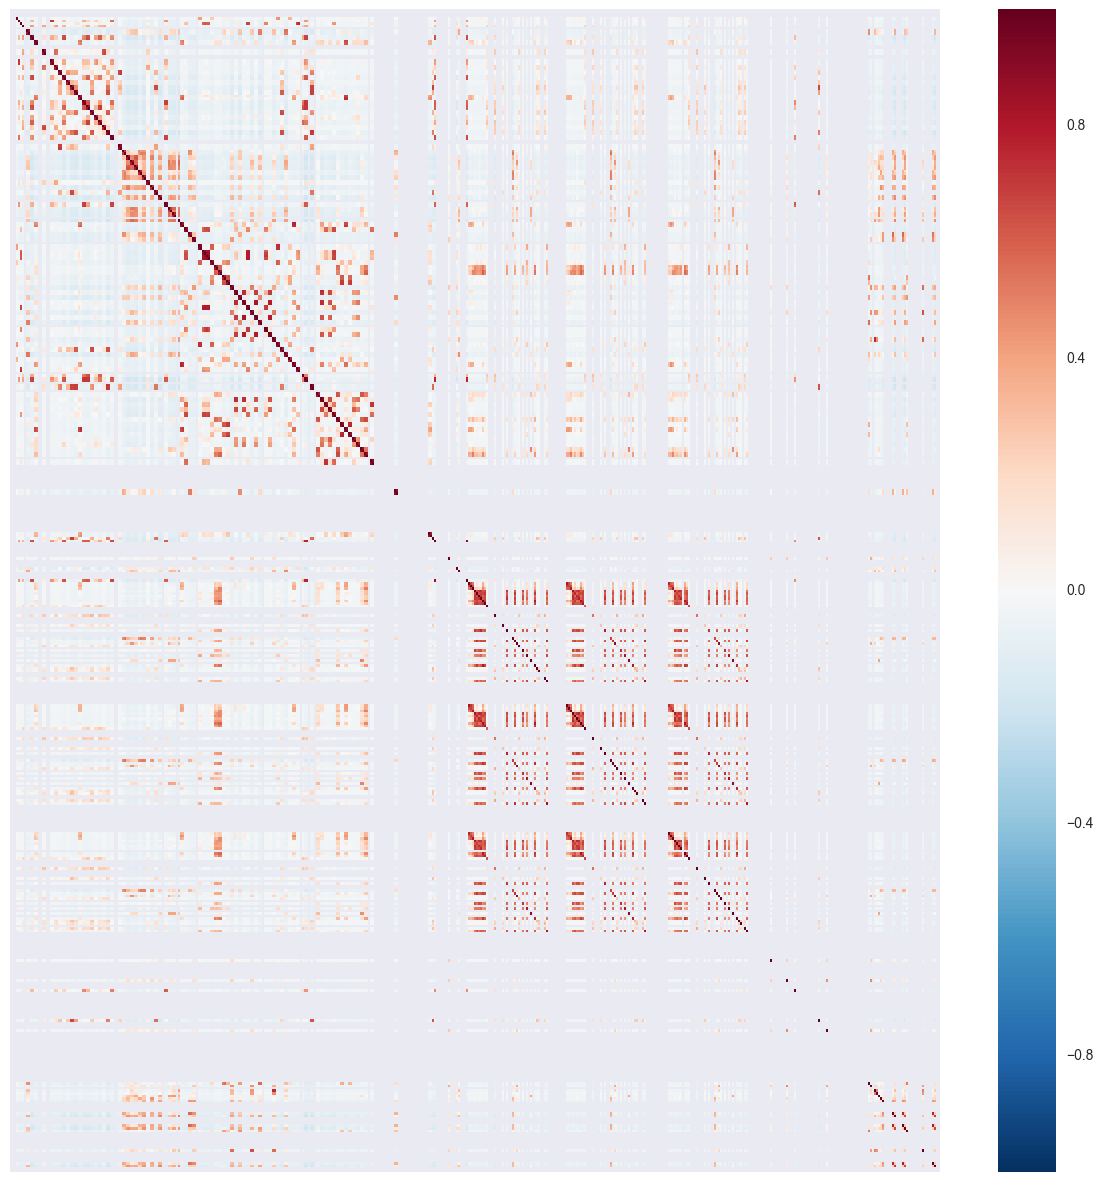

In [99]:
X_train_corr = pd.DataFrame(X_train_std).corr()

fig = plt.figure(figsize=(15,15))
sns.heatmap(X_train_corr,xticklabels=False, yticklabels=False)

Clearly, we observe clusters of predictors that are highly correlated. Let's assign a threshold of 0.8 and see how many predictor pairs have correlation above this threshold.

In [100]:
corr_stack = X_train_corr.stack()
corr_thresh = 0.8

# Total entries in correlation matrix above threshold
Nthresh = (abs(corr_stack) >= corr_thresh).sum()

# Subtracting the correlation of predictor with themselves which is equal to 1
Nthresh -= 465

# Pairwise correlations appear twice in the matrix
Nthresh *= 0.5

Nthresh

10.0

Only 10 predictor correlation pairs have correlation above our defined threshold. As they are a small number compared to the total number of predictors, I do not remove any at this stage. In general, we can remove half of these predictors in the following manner:

1. Determine the two predictors A and B with largest absolute pairwise correlation.

2. Determine average correlation between A and other predictors. Repeat this for B.

3. If A has a larger average correlation, remove it. Otherwise, remove B.

4. Repeat 1-3 until no absolute correlation is above threshold.

I found this technique in the Chapter 3 of **Applied Predictive Modeling** book. I've written a few personal notes on the most important information I learnt reading this chapter. You can [find it here](https://github.com/sharan-naribole/applied-predictive-modeling/blob/master/Chapter-3.md).

## Principal Component Analysis (PCA) <a id = "pca"></a>

Dimensionality reduction is one of the key techniques to reduce the complexity. 

PCA is a simple dimensionality reduction technique that applies linear transformations on the original space. Among all the orthogonal linear projections, PCA minimizes the **reconstruction error**, which is the distance between the instance and its reconstruction from the lower-dimensional space. That is sum of the distances between points in original space and the corresponding points in lower-dimensional space.

An important point to remember about PCA is that it is an **unsupervised** form of dimensionality reduction. This means the response variables are not taken into consideration at any point of the transformation. sci-kit learn provides convenient methods to perform PCA which I'll be using directly.

In [83]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

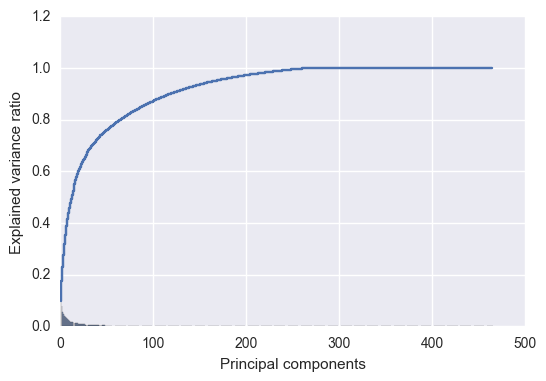

In [84]:
# Borrowed from Sebastian Raschka's Python Machine Learning Book - Chapter 5

plt.bar(range(1, 466), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 466), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

Over 90% of the variance is explained by first 200 eigen vectors. Before, we perform the dimensionality reduction on our data, let's analyze the reconstruction error as a function of the dimensions.

In [ ]:
recon_error = []

for k in range(1,X_train_std.shape[1] + 1):
    #print("Number of components", k)
    pca_recon = PCA(n_components=k)
    X_pca = pca_recon.fit_transform(X_train_std)
    #print(sum(pca_recon.explained_variance_ratio_))
    X_recon = pca_recon.inverse_transform(X_pca)
    recon_error.append(sum(np.ravel(np.abs(X_recon- X_train_std)**2)))
    
recon.plot()
plt.xlabel("Number of Eigen Vectors")
plt.ylabel("Reconstruction Error")    